# Multilingual Named Entity Recognition

- Dataset: Subset of Cross-lingual TRansfer Evaluation of Multilingual Encoders (XTREME) benchmark, PAN-X, which is a dataset of Wikipedia articles in different languages in IOB2 format 

In [1]:
from datasets import get_dataset_config_names
import pandas as pd
from IPython.core.display import display
import numpy as np

full_context = pd.option_context('display.max_rows', 10, 'display.max_columns', 500)

In [2]:
xtreme_subsets = get_dataset_config_names("xtreme")
len(xtreme_subsets)

183

This dataset has a lot of different configurations. Let's look at the PAN-X datasets:

In [3]:
[s for s in xtreme_subsets if s.startswith("PAN")][:10]

['PAN-X.af',
 'PAN-X.ar',
 'PAN-X.bg',
 'PAN-X.bn',
 'PAN-X.de',
 'PAN-X.el',
 'PAN-X.en',
 'PAN-X.es',
 'PAN-X.et',
 'PAN-X.eu']

In [4]:
from datasets import load_dataset, DatasetDict
from collections import defaultdict

In [5]:
langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]

panx = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # shuffle and downsample to spoken proportion
    for split in ds:
        panx[lang][split] = (ds[split]
                             .shuffle(seed=0)
                            .select(range(int(frac * ds[split].num_rows))))


Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
counts = pd.DataFrame({lang: [panx[lang]['train'].num_rows] for lang in langs}, index=["Number of training examples"])
counts/counts.sum(axis=1)[0]

,de,fr,it,en
Number of training examples,0.628372,0.228771,0.083916,0.058941


In [7]:
panx["de"]["train"][0]

{'tokens': ['2.000',
  'Einwohnern',
  'an',
  'der',
  'Danziger',
  'Bucht',
  'in',
  'der',
  'polnischen',
  'Woiwodschaft',
  'Pommern',
  '.'],
 'ner_tags': [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0],
 'langs': ['de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de']}

In [8]:
panx["de"]["train"].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None),
 'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

So the `ner_tags` are [IOB2 tags](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)).

In [9]:
tags = panx["de"]["train"].features["ner_tags"].feature
tags

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

In [10]:
from typing import Dict, List 

def create_tag_names(batch: Dict[str, List]) -> Dict[str, List]:
    return {'ner_tags_str': [tags.int2str(idx) for idx in batch["ner_tags"]]}

## Creating a custom model for token classification

NER can be viewed as token classification. Let's generate a custom model head for this purpose.

In [11]:
from typing import Optional

import torch
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.configuration_utils import PretrainedConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel, RobertaPreTrainedModel


class XLMRobertaForTokenClassification(RobertaPreTrainedModel):  # inherits from model body. Knows how to load pretrained weights.
    config_class = XLMRobertaConfig  # so that we use XLM-R config instead of Roberta

    def __init__(self, config: PretrainedConfig):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)  # return all hidden states, not just the [CLS] ones
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids: Optional[torch.Tensor] = None, attention_mask: Optional[torch.Tensor] = None,
                token_type_ids: Optional[torch.Tensor] = None, labels: Optional[torch.Tensor] = None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representations
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:            
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,
                                     attentions=outputs.attentions)


In [12]:
XLMRobertaForTokenClassification.__mro__

(__main__.XLMRobertaForTokenClassification,
 transformers.models.roberta.modeling_roberta.RobertaPreTrainedModel,
 transformers.modeling_utils.PreTrainedModel,
 torch.nn.modules.module.Module,
 transformers.modeling_utils.ModuleUtilsMixin,
 transformers.generation_utils.GenerationMixin,
 transformers.utils.hub.PushToHubMixin,
 object)

## Loading a custom model

In [13]:
tags.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

In [14]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [15]:
from transformers import AutoConfig, AutoTokenizer

In [16]:
xlmr_model_name = "xlm-roberta-base"

# Loading the config and overwriting parameters of the original pretrained model we want to change allows us to customize models
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, 
                                         num_labels=tags.num_classes, id2label=index2tag, label2id=tag2index)

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [17]:
import torch

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'roberta.e

In [19]:
# Test the tokenizer works
text = "Jack Sparrow loves New York!"
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

In [20]:
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids).logits
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=-1)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

In [21]:
tag_text(text, tags, xlmr_model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-LOC,O,O,O,O,O,O,O,O,B-LOC


In [22]:
ignore_index_value_in_loss = -100

def tokenize_and_align_labels(examples: Dict[str, List]) -> Dict[str, List]:
    """Create word-level labels to subword tokens"""
    
    # XLM tokenize a sentence into subwords, where the sentence is split into words
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        # assign a subword a word-level integer index, and None to special tokens like <s>, </s>
        word_ids = tokenized_inputs.word_ids(batch_index=idx)  
        
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                # We are following the convention that only the first subword token be associated with a classification
                # otherwise we will more heavily weight words that are broken up into multiple subtokens. Thus, when
                # word_idx == previous_word_idx, we will use a special label to tell the loss function to ignore this index
                # via the ignore_index flag for nn.CrossEntropyLoss
                label_ids.append(ignore_index_value_in_loss)
            else:
                label_ids.append(label[word_idx])
                previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


In [23]:
example = panx["de"]["train"][:3]
pd.DataFrame([example['tokens'][0]], index=['tokens'])

,0,1,2,3,4,5,6,7,8,9,10,11
tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.


In [24]:
tokenized_input = xlmr_tokenizer(example['tokens'][0], truncation=True, is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
example_labelled = tokenize_and_align_labels(panx["de"]["train"][:3])

with full_context:
    display(pd.DataFrame([tokens, example_labelled['labels'][0]], index=['tokens', 'labels']))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,t,▁in,▁der,▁polni,schen,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
labels,-100,0,0,-100,0,0,5,-100,-100,6,-100,0,0,5,-100,5,-100,-100,-100,6,-100,-100,0,-100,-100


In [25]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, remove_columns=['langs', 'ner_tags', 'tokens'])

In [26]:
panx_de_encoded = encode_panx_dataset(panx["de"])

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [27]:
panx_de_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
})

## Performance measures

In NER, *all* words of an entity must be predicted correctly in order for a prediction to be counted as correct. The library `seqeval` is designed for these kinds of tasks.

In [28]:
!pip install seqeval

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 182.4 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=a6832da33be16cb6a116583355eea4410120f01fb5c53a0309376c4478f30ad2
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [29]:
def align_predictions(predictions, label_ids):
    """Prepare model outputs for metric evaluation by seqeval"""
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs ignore_index_value_in_loss
            if label_ids[batch_idx, seq_idx] != ignore_index_value_in_loss:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
        
        labels_list.append(example_labels)
        preds_list.append(example_preds)
    return preds_list, labels_list

## Fine-tuning XLM-Roberta

Strategy:
- Fine-tune on the German (largest) subset of PAN-X
- Evaluate zero-shot cross-lingual performance on French, Italian, and English

In [30]:
from transformers import TrainingArguments

In [31]:
num_epochs = 3
batch_size=24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f'{xlmr_model_name}-finetuned-panx-de'
training_args = TrainingArguments(
    output_dir=f'/kaggle/working/{model_name}', log_level="error", num_train_epochs=num_epochs, 
    per_device_eval_batch_size=batch_size, per_gpu_train_batch_size=batch_size, evaluation_strategy="epoch",
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False, logging_steps=logging_steps, push_to_hub=False
)

In [32]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

Define a *data collator* to pad each input sequence to the largest sequence length in a batch.

In [33]:
from transformers import DataCollatorForTokenClassification

In [34]:
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

Definte a `model_init` function so that we can avoid initializing a new model for every `Trainer` 

In [35]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

Define trainer

In [36]:
from transformers import Trainer

In [37]:
str(device)

'cpu'

In [38]:
trained_path = f'/kaggle/working/{model_name}/trained'

if str(device) != 'cpu':
    trainer = Trainer(model_init=model_init, args=training_args, data_collator=data_collator, compute_metrics=compute_metrics,
                      train_dataset=panx_de_encoded["train"], 
                      eval_dataset=panx_de_encoded["validation"],
                      tokenizer=xlmr_tokenizer,
                     )
    trainer.train()
    trainer.save_model(trained_path)
    # Switch back to CPU when done

In [39]:
model = XLMRobertaForTokenClassification.from_pretrained(trained_path).to(device)

In [41]:
# test on an example text
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
with full_context:
    display(tag_text(text_de, tags, model, xlmr_tokenizer))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


## Error analysis

Get loss and predicted labels for validation set, and then observe examples with highest loss

In [42]:
from torch.nn.functional import cross_entropy

In [45]:
def forward_pass_with_label(batch):
    # prepare features for data collator by converting dict of lists to list of dicts
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        output = model(input_ids, attention_mask)
        # logit.size = [batch_size, sequence_length, classes]
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), reduction="none")
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    return {'loss': loss, 'predicted_label': predicted_label}

In [46]:
if str(device) != "cpu":
    valid_set = panx_de_encoded["validation"]
    valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
    valid_set.save_to_disk(f'/kaggle/working/{model_name}/validation/valid_set')

  0%|          | 0/197 [00:00<?, ?ba/s]

In [52]:
from datasets import load_from_disk

valid_set = load_from_disk(f'/kaggle/working/{model_name}/validation/valid_set')

In [53]:
df = valid_set.to_pandas()

In [54]:
df.head()

,input_ids,attention_mask,labels,loss,predicted_label
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[-100, 3, -100, 4, 4, 4, -100]","[0.0, 0.010982071, 0.0, 0.015253793, 0.0107771...","[4, 3, 4, 4, 4, 4, 0, 3, 3, 3, 3, 3, 3, 3, 3, ..."
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, -100, -100, -100, -100, 3, -100, -10...","[0.0, 0.00022337325, 0.0, 0.0, 0.0, 0.0, 0.561...","[0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 4, 4, 4, 4, ..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 0, 3, -100, -100, 0, -100, 0, ...","[0.0, 0.00027533554, 0.00012671144, 0.00023159...","[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 5, -100, 0, 0, -100]","[0.0, 0.00037817957, 0.00020287363, 0.00020859...","[0, 0, 0, 0, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, 3, ...","[0.0, 0.00014780859, 0.00013469743, 0.00013815...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, ..."


In [55]:
index2tag[-100] = "IGN"  # ignore code
df["input_tokens"] = df["input_ids"].apply(lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(lambda x: [index2tag[i] for i in x])

In [56]:
df["labels"] = df['labels'].apply(lambda x: [index2tag[i] for i in x])
df["loss"] = df.apply(lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df["predicted_label"] = df.apply(lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)

In [57]:
df.head()

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.010982071, 0.0, 0.015253793, 0.0107771...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, IGN, IGN, IGN, IGN, B-ORG, IGN, IGN, ...","[0.0, 0.00022337325, 0.0, 0.0, 0.0, 0.0, 0.561...","[O, O, O, O, O, O, B-ORG, I-ORG, I-ORG, I-ORG,...","[<s>, ▁WE, ITE, RL, EIT, UNG, ▁Luz, ky, j, ▁a,..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, O, O, O, B-ORG, IGN, IGN, O, IGN, O, ...","[0.0, 0.00027533554, 0.00012671144, 0.00023159...","[O, O, O, O, O, B-ORG, O, O, O, O, O, O, O, O]","[<s>, ▁entdeckt, ▁und, ▁gehört, ▁der, ▁Spek, t..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, O, O, B-LOC, IGN, O, O, IGN]","[0.0, 0.00037817957, 0.00020287363, 0.00020859...","[O, O, O, O, B-LOC, I-LOC, O, O, O]","[<s>, ▁**, ▁', ▁'', ▁, Bretagne, ▁'', ▁', </s>]"
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, O, O, O, O, O, O, IGN, O, O, O, B-ORG...","[0.0, 0.00014780859, 0.00013469743, 0.00013815...","[O, O, O, O, O, O, O, O, O, O, O, O, B-ORG, I-...","[<s>, ▁Nach, ▁einem, ▁Jahr, ▁bei, ▁diesem, ▁Ve..."


In [58]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens.head()

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.010982,B-ORG,▁Ham
0,15,1,I-ORG,0.015254,I-ORG,▁(
0,16104,1,I-ORG,0.010777,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.018821,I-ORG,▁)
1,56530,1,O,0.000223,O,▁WE


In [63]:
(df_tokens.groupby("input_tokens")[["loss"]]
 .agg(["count", "mean", "sum"])
 .droplevel(level=0, axis=1)
 .sort_values(by="sum", ascending=False)
 .reset_index()
 .round(2)
 .head(10)
 .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁in,▁von,▁und,▁(,▁/,▁),▁'',▁die
count,6066,1388,989,808,1171,246,163,246,2898,860
mean,0.04,0.1,0.13,0.14,0.08,0.33,0.49,0.3,0.03,0.06
sum,220.886353,136.082352,128.466568,116.45929,97.961334,80.860657,79.478256,72.718269,72.577118,49.512142


- Whitespace has largest total loss, but the mean loss is quite small
- Words like "in", "der", "von" appear frequently and appear with named entities, which explains why they might get frequently mixed up
- Parentheses and slashes seem to have quite a high loss. We could take a look at some corresponding example sequences and dig further into potential data issues.

In [76]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

In [85]:
def plot_confusion_matrix(y_true, y_preds, labels):
    cm = confusion_matrix(y_true, y_preds, labels=labels, normalize='true')
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")


In [81]:
df_tokens.head()

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.010982,B-ORG,▁Ham
0,15,1,I-ORG,0.015254,I-ORG,▁(
0,16104,1,I-ORG,0.010777,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.018821,I-ORG,▁)
1,56530,1,O,0.000223,O,▁WE


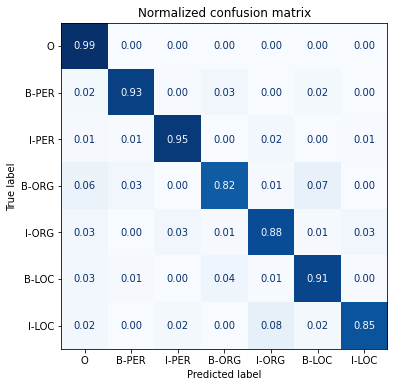

In [86]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"], tags.names)

- We can also look at sequences with a large total loss (for another time). This can help us discover mislabelled data.

## Cross-lingual transfer

In [93]:
trainer = Trainer(model, data_collator=data_collator, compute_metrics=compute_metrics)

In [94]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics['test_f1']

In [95]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

***** Running Prediction *****
  Num examples = 6290
  Batch size = 8


F1-score of [de] model on [de] dataset: 0.867


In [97]:
# Try a French example
text_fr = "Jeff Dean est informaticien chez Google en Californie"
with full_context:
    display(tag_text(text_fr, tags, trainer.model, xlmr_tokenizer))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,B-LOC,I-LOC,O


In [99]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [100]:
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 2290
  Batch size = 8


F1-score of [de] model on [fr] dataset: 0.703


Impressive given that the model has not seen a single French label!